In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import pickle
import os
import sys

CURR_DIR = os.path.dirname(os.path.realpath("__file__"))
ROOT_DIR = os.path.abspath(os.path.join(CURR_DIR))
LIB_DIR = os.path.join(ROOT_DIR, 'libs')
EXP_DIR = os.path.join(CURR_DIR, "doublependulum_exp")
sys.path.append(LIB_DIR)

In [2]:
def get_global_bests(hist_fit: list) -> list:
    """globalベストのリストを返す

    Args:
        hist_fit (list): 各世代の最良適応度のリスト

    Returns:
        list: globalベストのリスト
    """
    global_bests = [hist_fit[0]]
    for i in range(1, len(hist_fit)):
        if hist_fit[i] > global_bests[-1]:
            global_bests.append(hist_fit[i])
        else:
            global_bests.append(global_bests[-1])

    return global_bests

def get_mean_std(df_hist_pop: pd.DataFrame) -> tuple:
    """各世代の平均適応度、標準偏差を返す

    Args:
        df_hist_pop (pd.DataFrame): 各世代の適応度のDataFrame

    Returns:
        tuple: 各世代の平均適応度、標準偏差のリスト
    """
    hist_avg_fit = df_hist_pop.groupby("generation").mean()["fitness"].values
    hist_std_fit = df_hist_pop.groupby("generation").std()["fitness"].values

    return (hist_avg_fit, hist_std_fit)

def get_species_statistics(df_hist_pop: pd.DataFrame) -> dict:
    """各種の統計データを返す

    Args:
        df_hist_pop (pd.DataFrame): 各世代の適応度のDataFrame

    Returns:
        dict: 各種の統計データの辞書, {種のID: {"created": 種の生成世代, "extinct": 種の絶滅世代, "ancestor": 祖先の種ID, "fitness_hist_average": 適応度の平均リスト, "fitness_hist_std": 適応度の標準偏差リスト}}
    """
    max_gen = df_hist_pop["generation"].max() # 終了世代
    species_data = {}
    for key in df_hist_pop["species"].unique():
        current_species = df_hist_pop[df_hist_pop["species"] == key] # 現在の種の行のみを取得

        ### 種の生存期間
        created = current_species["generation"].min()     # 種の生成世代
        extinct = current_species["generation"].max() + 1 # 種の絶滅世代（計算上，種が消されるのは次の世代）

        ### 祖先の種の取得
        first_genome_parent = current_species['parent1'].iloc[0] # 種に属する最初の個体の親から派生元の種を特定
        if first_genome_parent==-1:
                # 初期個体の場合は祖先なし
                ancestor = -1
        else:
            # 祖先の種を特定
            ancestor = df_hist_pop['species'].iloc[(df_hist_pop['id']==first_genome_parent).idxmax()] # 種に属する最初の個体の親idが最後に所属した種id

        ### 種の適応度の推移
        fitness_hist_average = np.array(current_species.groupby("generation").mean()["fitness"].values)
        fitness_hist_std = np.array(current_species.groupby("generation").std()["fitness"].values)

        fitness_hist_average_zeros = np.zeros(max_gen+1)
        fitness_hist_average_zeros[created:extinct] = fitness_hist_average
        fitness_hist_std_zeros = np.zeros(max_gen+1)
        fitness_hist_std_zeros[created:extinct] = fitness_hist_std

        fitness_hist_average = fitness_hist_average_zeros
        fitness_hist_std = fitness_hist_std_zeros

        species_data[key] = {
            "created": created,
            "extinct": extinct,
            "ancestor": ancestor,
            "fitness_hist_average": fitness_hist_average,
            "fitness_hist_std": fitness_hist_std
        }

    return species_data

def get_species_order(species_data: dict) -> list:
    """種の生成世代順に並べたリストを返す

    Args:
        species_data (dict): 種の統計データの辞書

    Returns:
        list: 種の生成世代順に並べたリスト
    """
    order = []
    stack = [-1] # 祖先なしの種にはancestor=-1が設定されているため，-1を初期値としてstackに追加
    while len(stack)>0:
        k = stack.pop(0)
        for key,species in species_data.items():
            if species['ancestor']==k:
                stack.insert(0, key) # stackの先頭にkeyを挿入
        order.append(k) # stackから取り出したkeyをorderに追加
    order = order[1:]  # 最初の-1を削除

    return order

def get_num_species_hist(df_hist_pop: pd.DataFrame) -> np.ndarray:
    """各世代の種の数のリストを返す

    Args:
        df_hist_pop (pd.DataFrame): 各世代の適応度のDataFrame

    Returns:
        np.ndarray: 各世代の種の数のリスト
    """
    df_hist_group_gen = df_hist_pop.groupby("generation")
    num_species_hist = np.array([len(df_hist_group_gen.get_group(i)["species"].unique()) for i in range(df_hist_pop["generation"].max()+1)])

    return num_species_hist

# 所属する種の変更回数（移籍回数）の履歴を取得
def get_num_species_transfers_hist(df_hist_pop: pd.DataFrame) -> np.ndarray:
    """各世代の所属する種の変更回数（移籍回数）のリストを返す

    Args:
        df_hist_pop (pd.DataFrame): 各世代の適応度のDataFrame

    Returns:
        np.ndarray: 各世代の所属する種の変更回数（移籍回数）のリスト
    """
    df_hist_group_gen = df_hist_pop.groupby("generation")

In [3]:
CURR_DIR = os.path.dirname(os.path.realpath("__file__"))
EXP_DIR = os.path.join(CURR_DIR, "doublependulum_exp")
data_dirs = os.listdir(EXP_DIR)
exp_name_uniques = []
for data_dir in data_dirs:
    if data_dir.split("_")[0] not in exp_name_uniques:
        exp_name_uniques.append(data_dir.split("_")[0])

In [4]:
exp_name_uniques

['elitencocontraseed5layer4',
 'elitencocontraseed5layer5',
 'elitencocontraseed5',
 'elitencocontra',
 'elitencoleakconstrand',
 'elitencoleak',
 'elitenco',
 'elits1001001',
 'elits100100novelty.png',
 'elits100100',
 'elits100400novelty.png',
 'elits100400',
 'elits200200novelty.png',
 'elits200200',
 'elits50200novelty.png',
 'elits50200',
 'elitsnothnovelty.png',
 'elitsnoth',
 'elitsnovelty.png',
 'elitsupdateelit100100novelty.png',
 'elitsupdateelit100100',
 'elitsupdateelit10050novelty.png',
 'elitsupdateelit10050',
 'elitsupdateelitnovelty.png',
 'elitsupdateelit',
 'elits',
 'hybsmre01elitts32v2',
 'hybsmre01elitts32',
 'hybsmre01ts32ch',
 'hybsmre01ts32ctp',
 'hybsmre01ts32ep0507',
 'hybsmre01ts32stepnocycle',
 'hybsmre01ts32step',
 'hybsmre01ts32ts32',
 'hybsmre01ts32v2',
 'hybsmre01ts32',
 'hybsmre01',
 'hybsmrerandommutate',
 'kanneatnocrossover',
 'kanneat',
 'nocrossover',
 'normalep07',
 'normal',
 'ns1',
 'ns',
 'nts32ep07',
 'nts32',
 'smr001',
 'smr01',
 'smre01ep07

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\daiki\\Documents\\neats\\experiments\\doublependulum_neat\\out\\doublependulum_exp\\elits100100novelty.png\\history_score.csv'

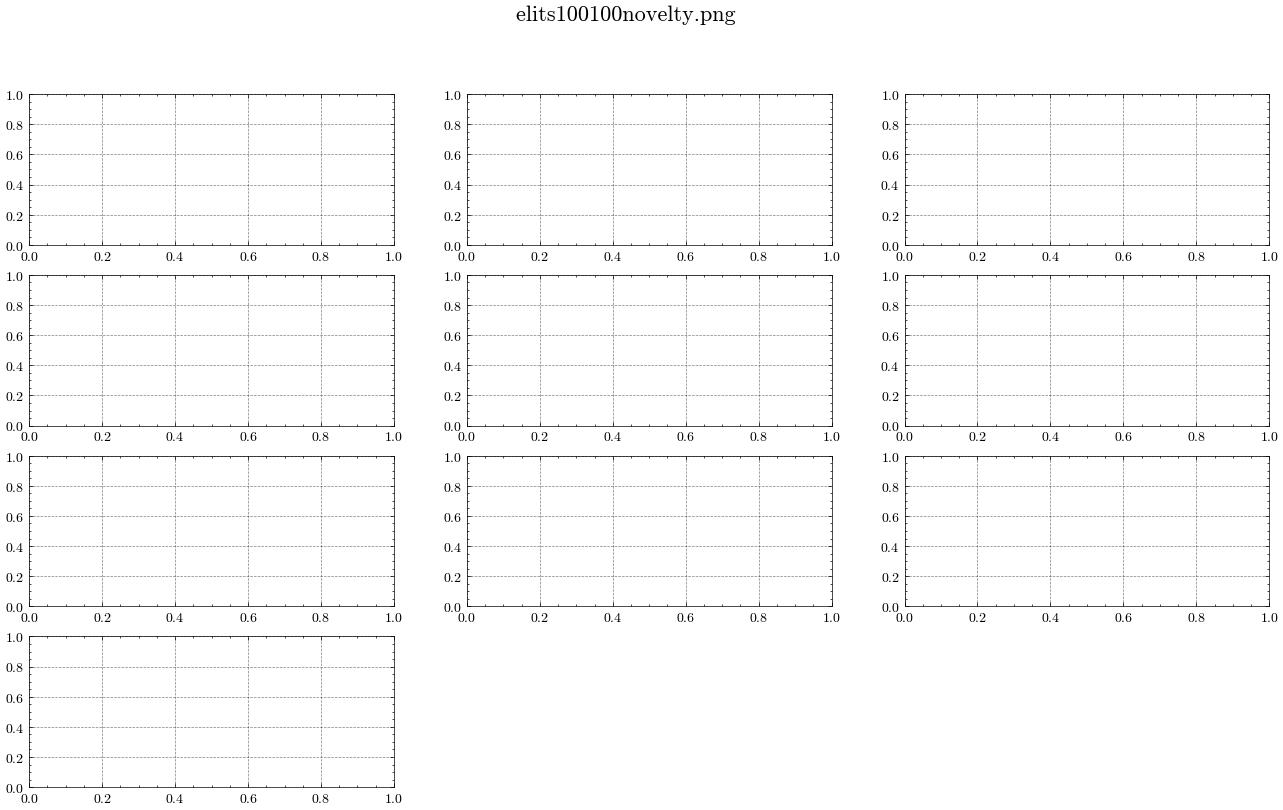

In [5]:
num_trials = 10

for exp_name in exp_name_uniques:
    if os.path.exists(os.path.join(EXP_DIR, f"{exp_name}_fitness.png")):
        continue
    exp_traials = [data_dir for data_dir in data_dirs if data_dir.split("_")[0]==exp_name]
    exp_traials.sort()

    num_row = int(np.ceil(num_trials/3))
    plt.style.use(['science', 'grid', 'no-latex'])
    fig = plt.figure(figsize=(16, 9))
    fig.suptitle(f"{exp_name} ", fontsize=16)
    axs = [fig.add_subplot(num_row, 3, i+1) for i in range(num_trials)]
    # y軸は0から10000に固定
    for i, exp_trial in enumerate(exp_traials[:num_trials]):
        try:
            df_history_fitness = pd.read_csv(os.path.join(EXP_DIR, exp_trial, "history_fitness.csv"))
        except:
            df_history_fitness = pd.read_csv(os.path.join(EXP_DIR, exp_trial, "history_score.csv"))

        df_history_pop = pd.read_csv(os.path.join(EXP_DIR, exp_trial, "history_pop.csv"))

        global_bests = get_global_bests(df_history_fitness["fitness"].values)
        hist_avg_fit, hist_std_fit = get_mean_std(df_history_pop)

        axs[i].plot(global_bests, label="Global Best", color="red")
        axs[i].plot(hist_avg_fit, label="Mean", color="green")
        axs[i].fill_between(range(len(global_bests)), hist_avg_fit-hist_std_fit, hist_avg_fit+hist_std_fit, alpha=0.3, label="Mean $\pm$ Std", color="blue")
        axs[i].set_ylim(0, 10000)
        axs[i].set_title(f"Trial {i+1}")
        axs[i].set_xlabel("Generation")
        axs[i].set_ylabel("Fitness")
        if i == num_trials-1:
            axs[i].legend()

    plt.tight_layout()
    plt.savefig(os.path.join(EXP_DIR, f"{exp_name}_fitness.png"))
    plt.show()
    plt.close()

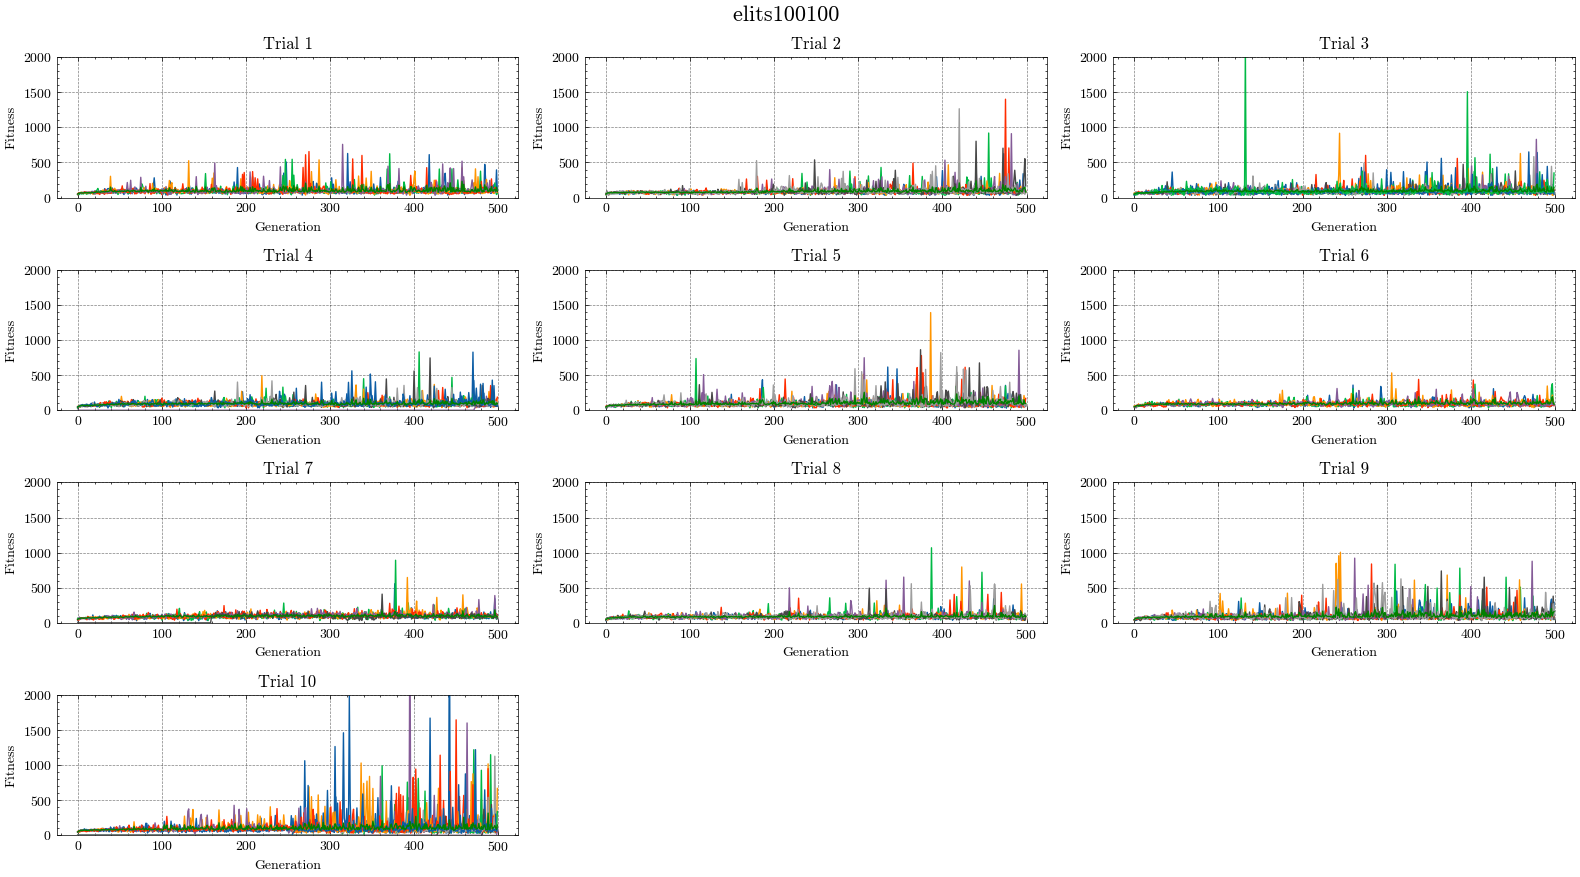

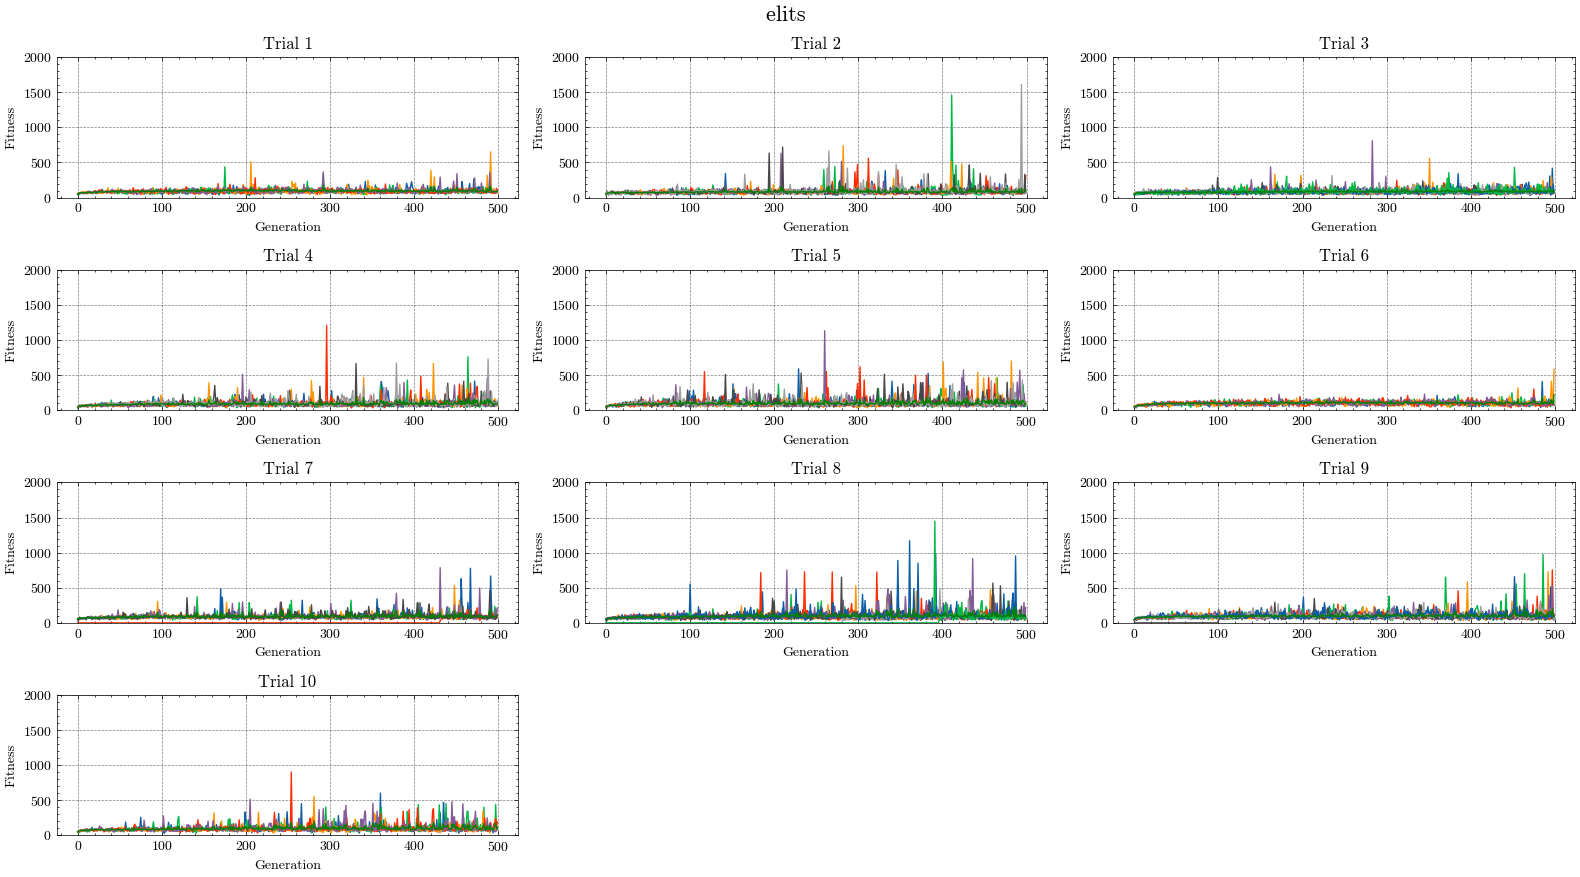

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\daiki\\Documents\\neats\\experiments\\doublependulum_neat\\out\\doublependulum_exp\\hybsmre01ts32ctp_fitness.png\\history_pop.csv'

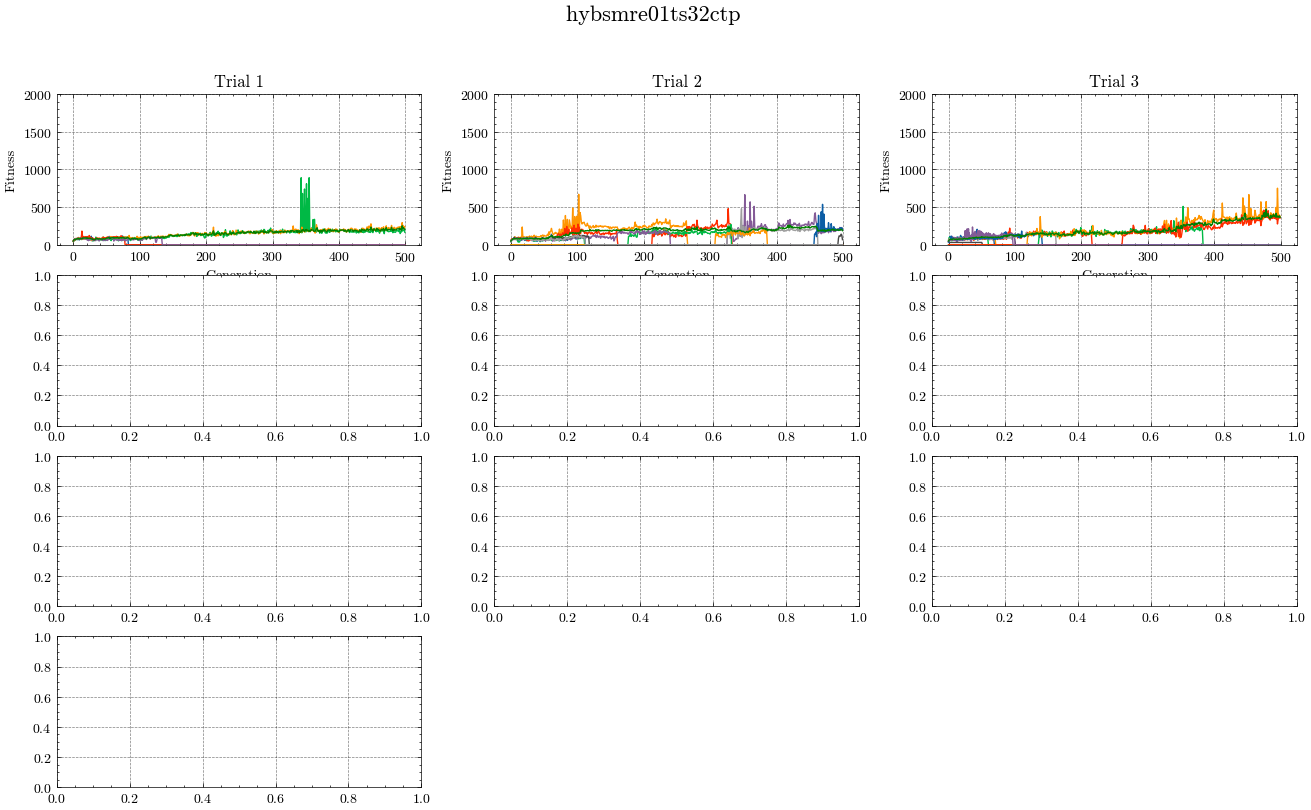

In [6]:
num_trials = 10

for exp_name in exp_name_uniques:
    if os.path.exists(os.path.join(EXP_DIR, f"{exp_name}_species_fit.png")):
        continue
    exp_traials = [data_dir for data_dir in data_dirs if data_dir.split("_")[0]==exp_name]
    exp_traials.sort()
    num_row = int(np.ceil(num_trials/3))
    plt.style.use(['science', 'grid', 'no-latex'])
    fig = plt.figure(figsize=(16, 9))
    fig.suptitle(f"{exp_name} ", fontsize=16)
    axs = [fig.add_subplot(num_row, 3, i+1) for i in range(num_trials)]
    for i, exp_trial in enumerate(exp_traials[:num_trials]):
        df_history_pop = pd.read_csv(os.path.join(EXP_DIR, exp_trial, "history_pop.csv"))
        species_data = get_species_statistics(df_history_pop)
        species_order = get_species_order(species_data)
        for key in species_order:
            species = species_data[key]
            mean_fit = species["fitness_hist_average"]
            
            axs[i].plot(mean_fit, label=f"Species {key}")

        hist_avg_fit, hist_std_fit = get_mean_std(df_history_pop)
        axs[i].plot(hist_avg_fit, label="Mean", color="green")
        axs[i].set_ylim(0, 2000)
        axs[i].set_title(f"Trial {i+1}")
        axs[i].set_xlabel("Generation")
        axs[i].set_ylabel("Fitness")
        # if i == num_trials-1:
        #     axs[i].legend()

    plt.tight_layout()
    plt.savefig(os.path.join(EXP_DIR, f"{exp_name}_species_fit.png"))
    plt.show()
    plt.close()

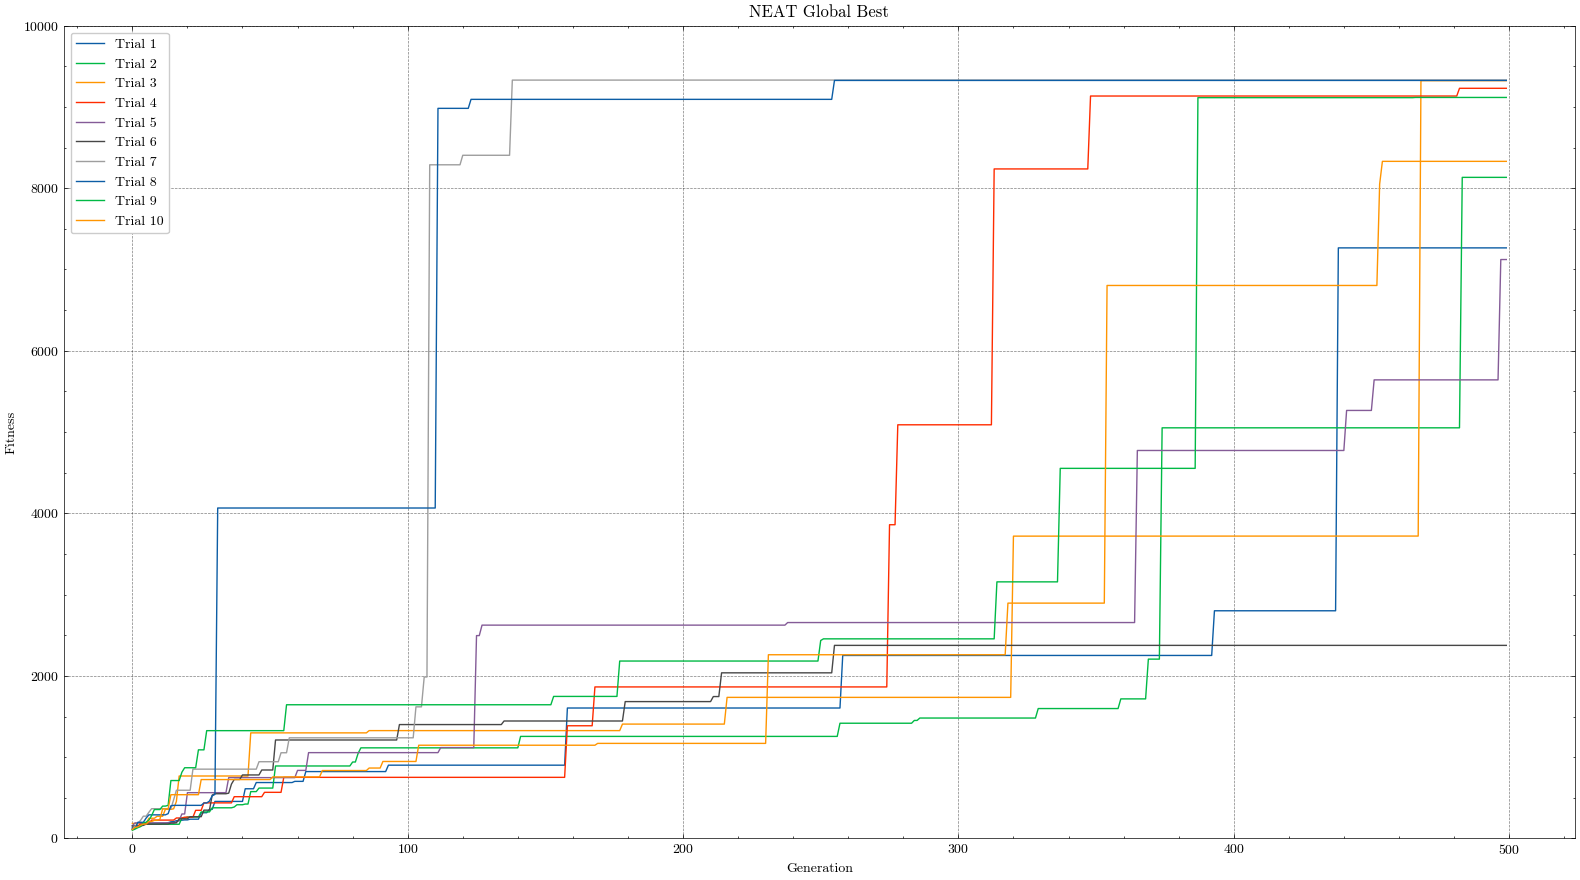

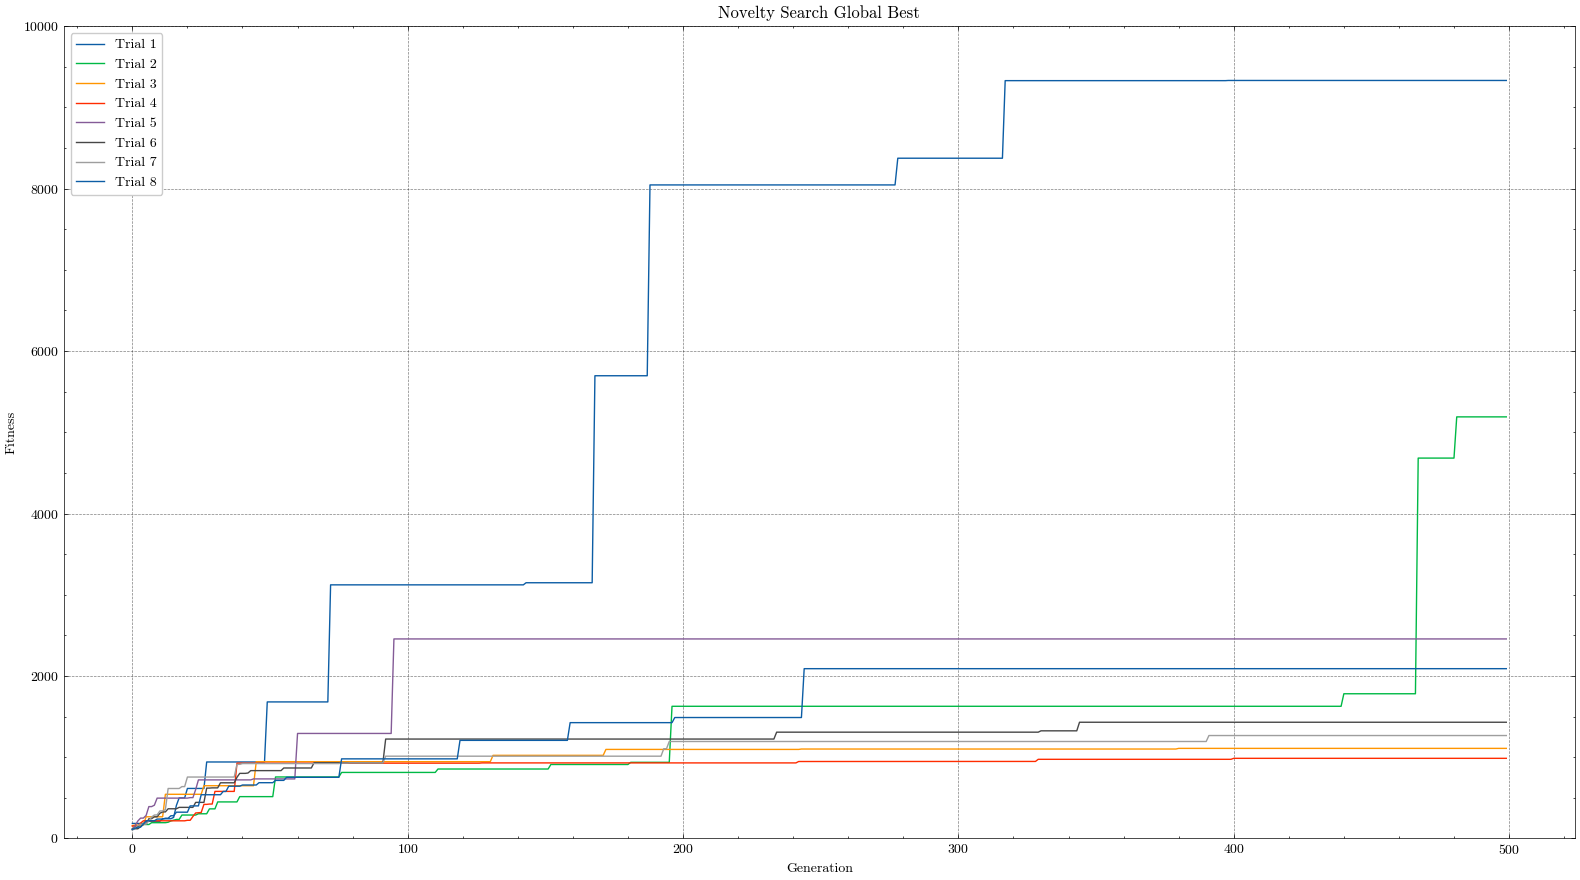

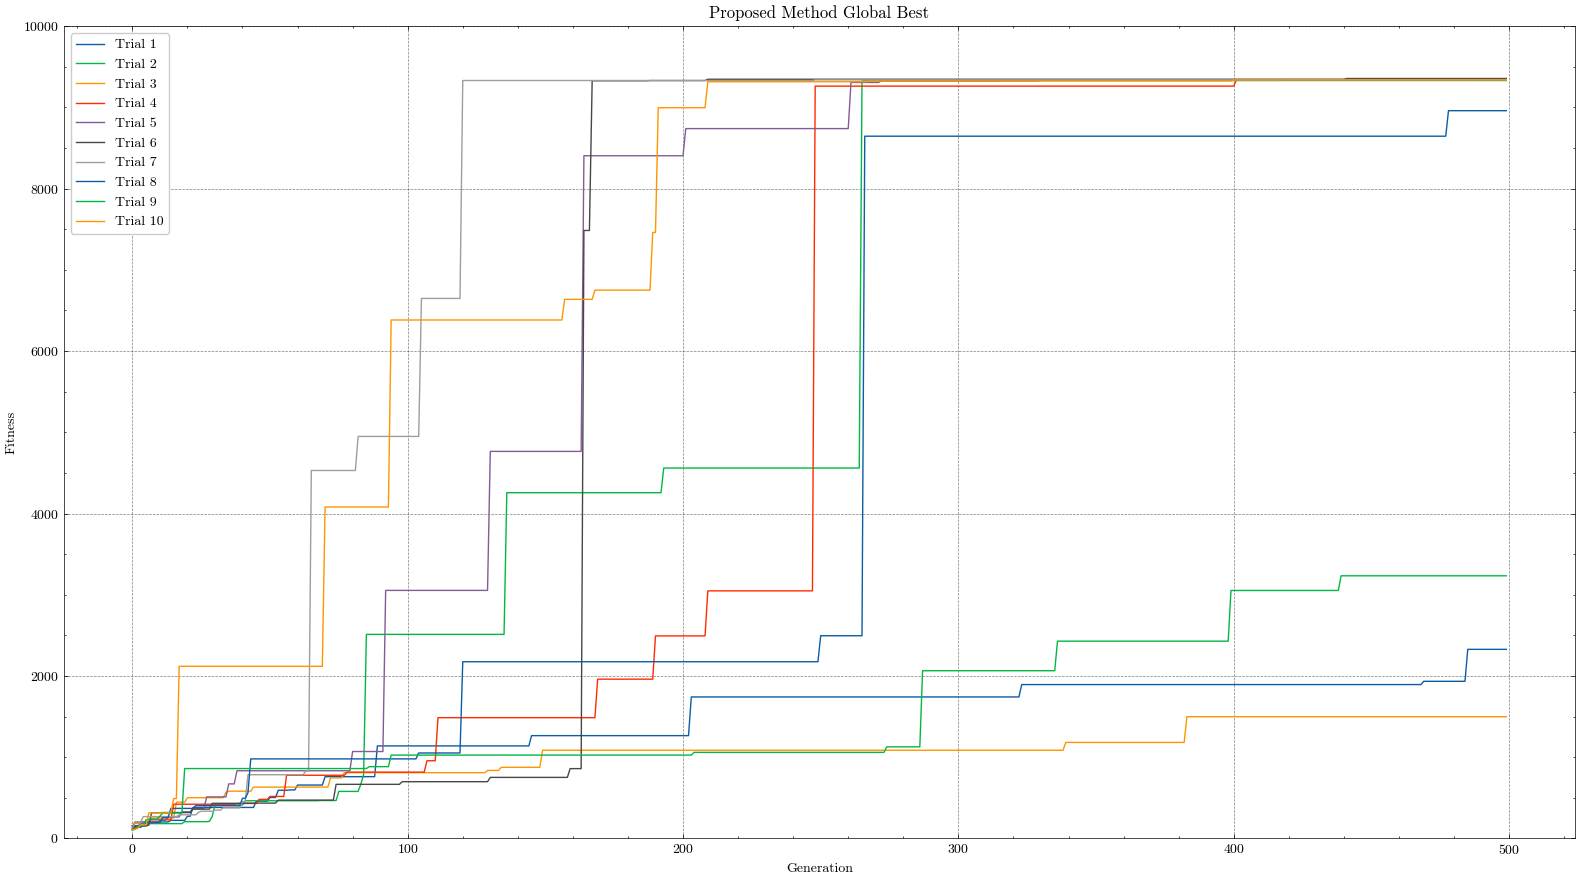

In [22]:
num_trials = 10

exp_name_uniques = ["normal", "ns1", "elits"]
alog_name = ["NEAT", "Novelty Search", "Proposed Method"]

for idx, exp_name in enumerate(exp_name_uniques):
    # if os.path.exists(os.path.join(EXP_DIR, f"{exp_name}_global_best.png")):
    #     continue
    exp_traials = [data_dir for data_dir in data_dirs if data_dir.split("_")[0]==exp_name]
    exp_traials.sort()

    num_row = int(np.ceil(num_trials/3))
    plt.style.use(['science', 'grid', 'no-latex'])
    fig = plt.figure(figsize=(16, 9))

    for i, exp_trial in enumerate(exp_traials[:num_trials]):
        try:
            df_history_fitness = pd.read_csv(os.path.join(EXP_DIR, exp_trial, "history_fitness.csv"))
        except:
            df_history_fitness = pd.read_csv(os.path.join(EXP_DIR, exp_trial, "history_score.csv"))

        try:
            global_bests = get_global_bests(df_history_fitness["fitness"].values)
        except:
            global_bests = get_global_bests(df_history_fitness["score"].values)

        plt.plot(global_bests, label=f"Trial {i+1}")

    plt.title(f"{alog_name[idx]} Global Best")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.ylim(0, 10000)
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(EXP_DIR, f"{exp_name}_global_best.png"))
    plt.show()
    plt.close()

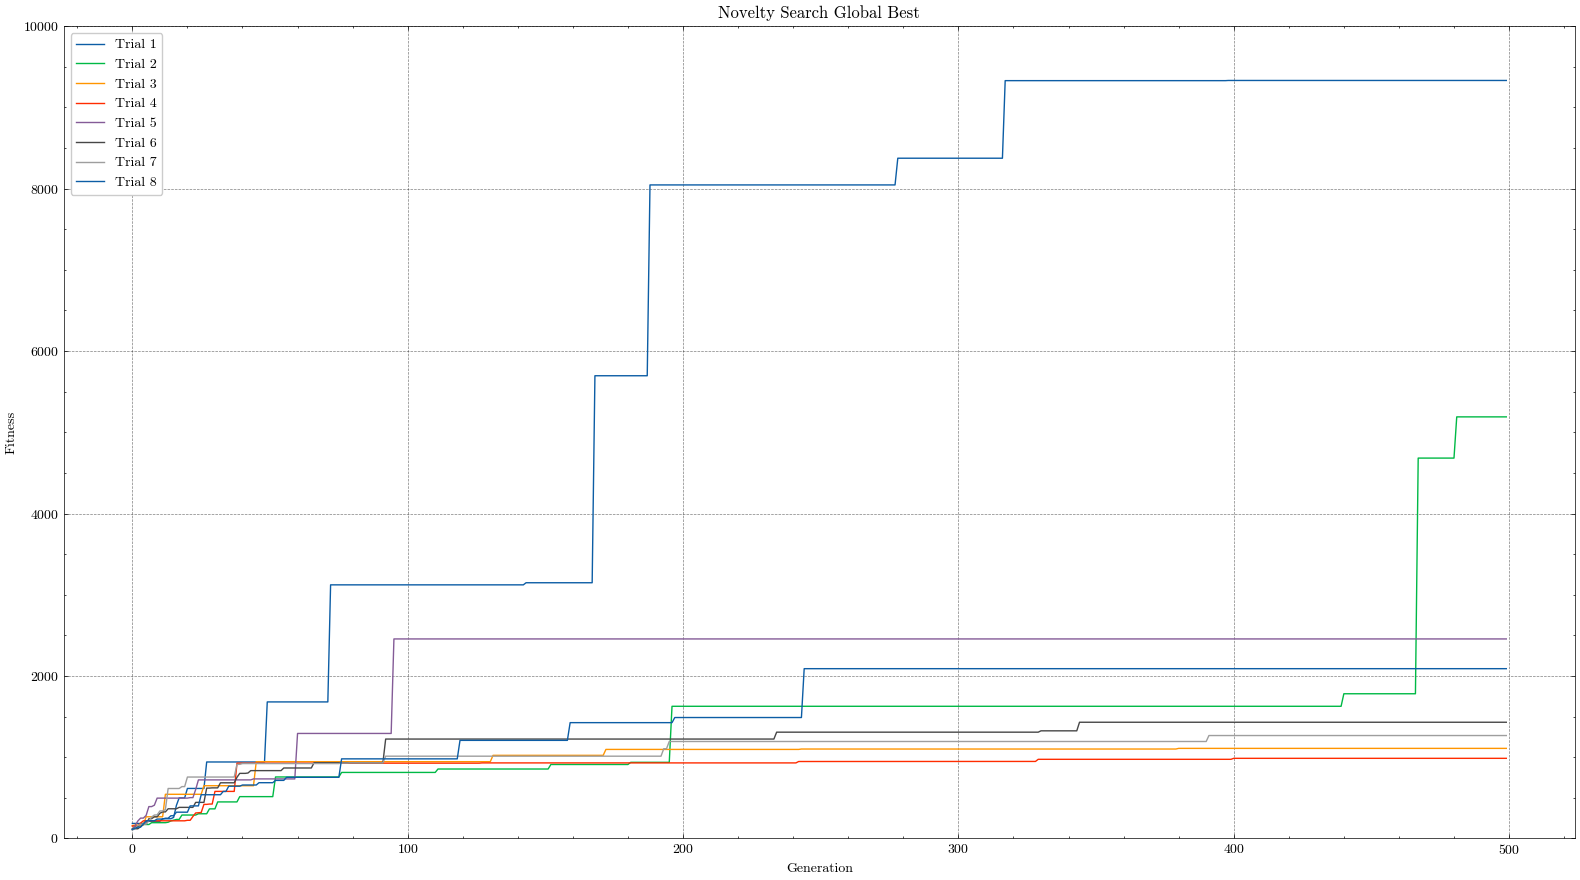

In [21]:
num_trials = 10

exp_name_uniques = ["ns1"]
alog_name = ["Novelty Search"]

for idx, exp_name in enumerate(exp_name_uniques):
    # if os.path.exists(os.path.join(EXP_DIR, f"{exp_name}_global_best.png")):
    #     continue
    exp_traials = [data_dir for data_dir in data_dirs if data_dir.split("_")[0]==exp_name]
    exp_traials.sort()

    num_row = int(np.ceil(num_trials/3))
    plt.style.use(['science', 'grid', 'no-latex'])
    fig = plt.figure(figsize=(16, 9))

    for i, exp_trial in enumerate(exp_traials[:num_trials]):
        df_history_fitness = pd.read_csv(os.path.join(EXP_DIR, exp_trial, "history_score.csv"))

        try:
            global_bests = get_global_bests(df_history_fitness["fitness"].values)
        except:
            global_bests = get_global_bests(df_history_fitness["score"].values)

        plt.plot(global_bests, label=f"Trial {i+1}")

    plt.title(f"{alog_name[idx]} Global Best")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.ylim(0, 10000)
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(EXP_DIR, f"{exp_name}_global_best.png"))
    plt.show()
    plt.close()

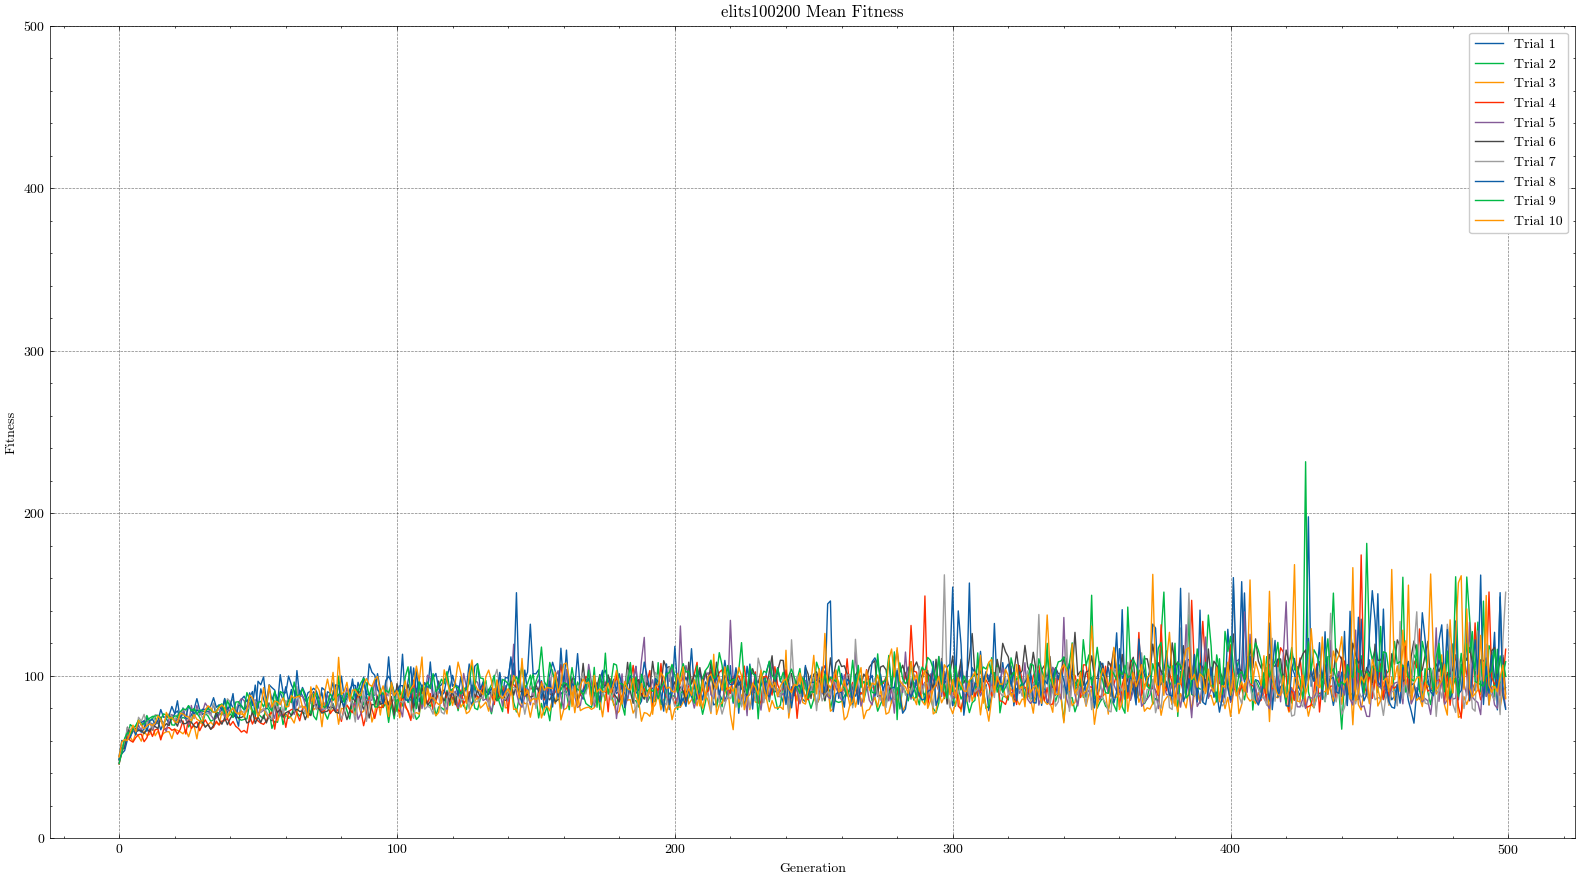

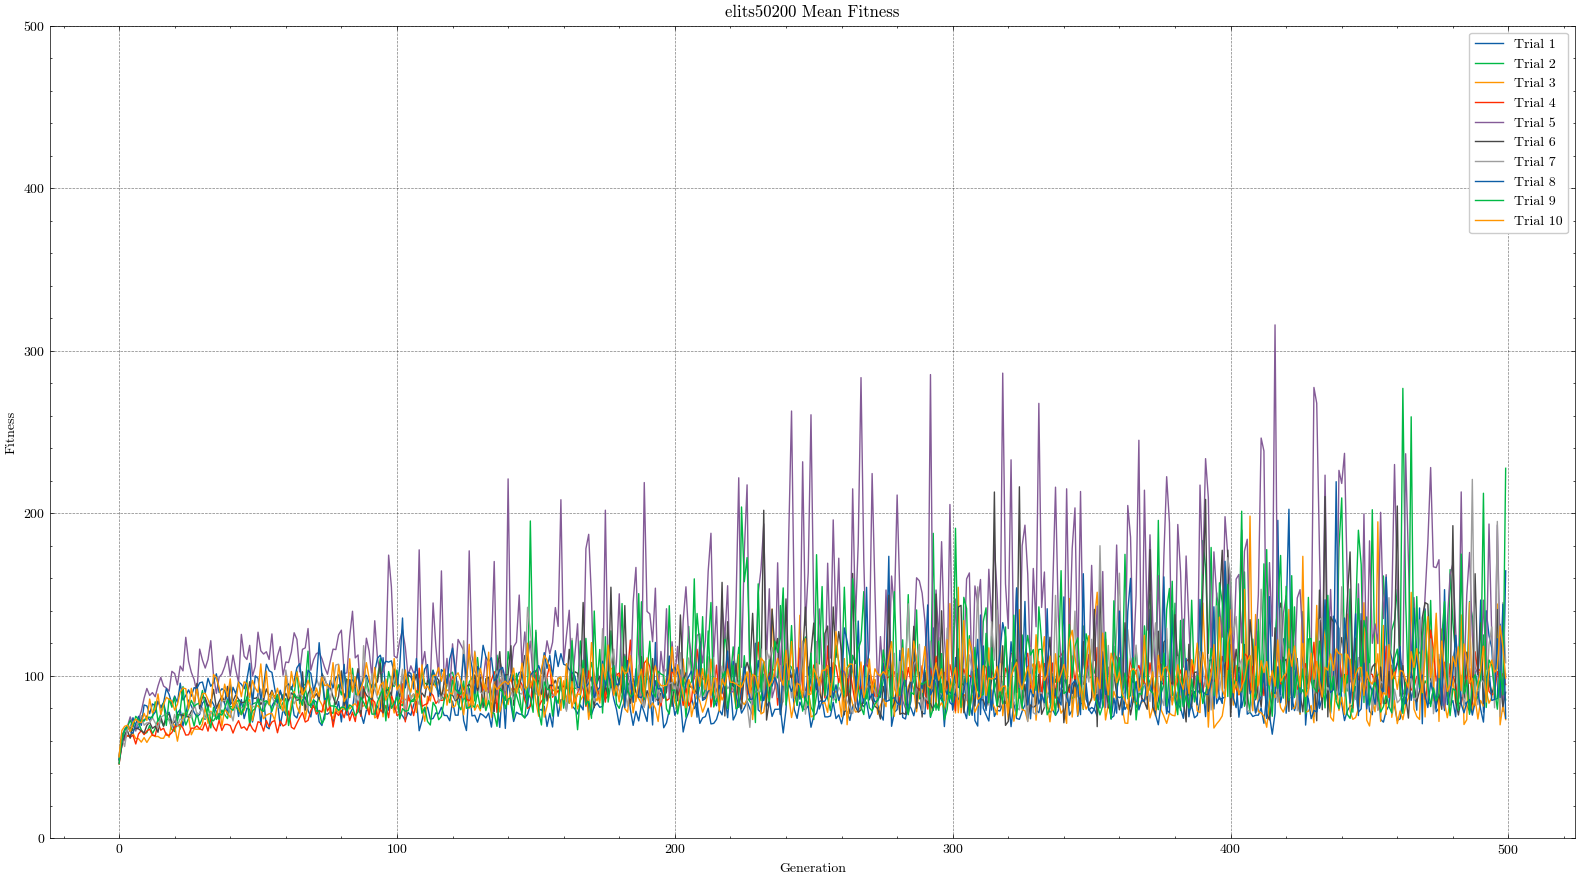

In [7]:
num_trials = 10

for exp_name in exp_name_uniques:
    if os.path.exists(os.path.join(EXP_DIR, f"{exp_name}_mean_fit.png")):
        continue
    exp_traials = [data_dir for data_dir in data_dirs if data_dir.split("_")[0]==exp_name]
    exp_traials.sort()

    num_row = int(np.ceil(num_trials/3))
    plt.style.use(['science', 'grid', 'no-latex'])
    fig = plt.figure(figsize=(16, 9))

    for i, exp_trial in enumerate(exp_traials[:num_trials]):
        df_history_pop = pd.read_csv(os.path.join(EXP_DIR, exp_trial, "history_pop.csv"))
        mean_fit, _ = get_mean_std(df_history_pop)

        plt.plot(mean_fit, label=f"Trial {i+1}")

    plt.title(f"{exp_name} Mean Fitness")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.ylim(0, 500)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(EXP_DIR, f"{exp_name}_mean_fit.png"))
    plt.show()
    plt.close()

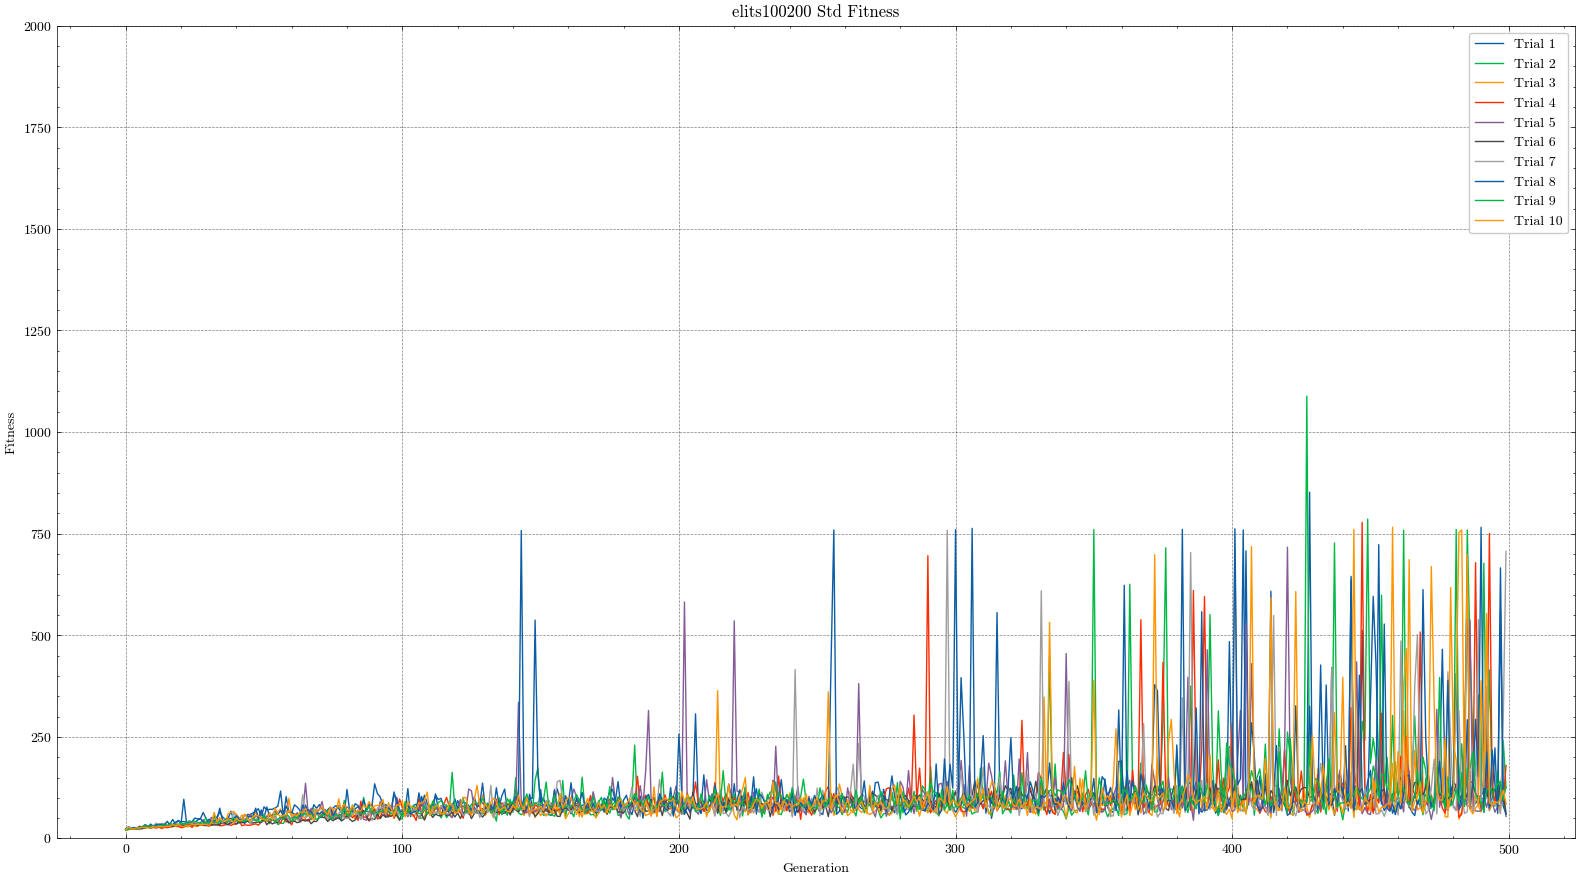

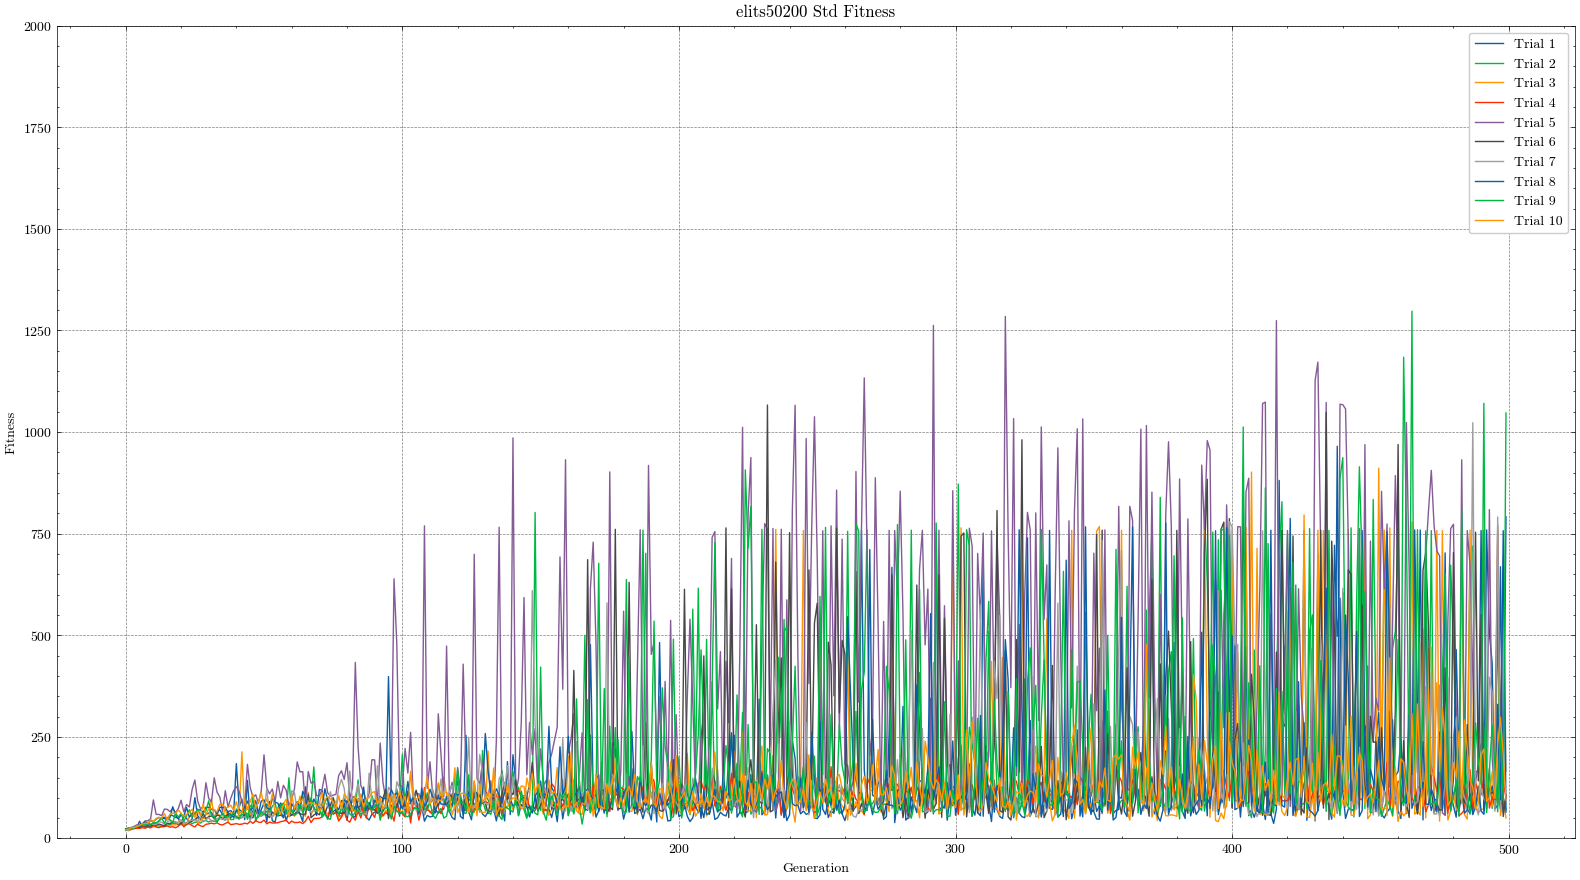

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\daiki\\Documents\\neats\\experiments\\doublependulum_neat\\out\\doublependulum_exp\\hybsmre01ts32ctp_fitness.png\\history_pop.csv'

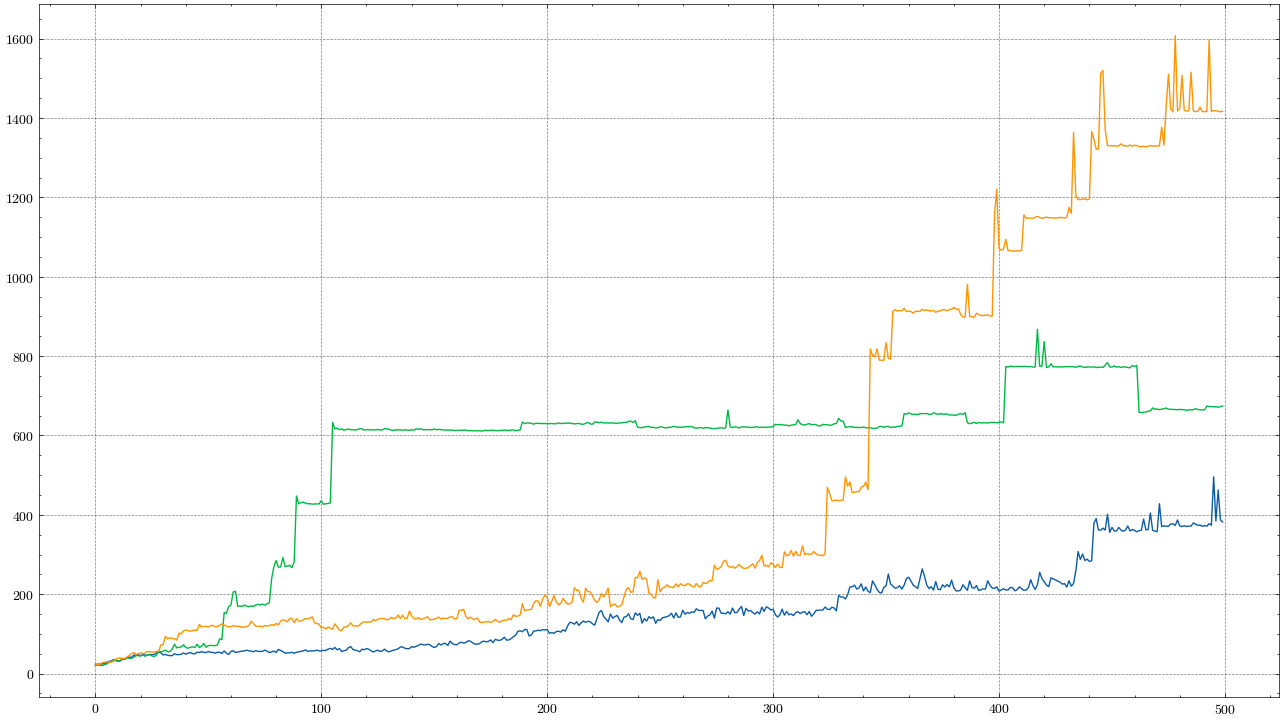

In [8]:
num_trials = 10

for exp_name in exp_name_uniques:
    if os.path.exists(os.path.join(EXP_DIR, f"{exp_name}_std_fit.png")):
        continue
    exp_traials = [data_dir for data_dir in data_dirs if data_dir.split("_")[0]==exp_name]
    exp_traials.sort()

    num_row = int(np.ceil(num_trials/3))
    plt.style.use(['science', 'grid', 'no-latex'])
    fig = plt.figure(figsize=(16, 9))

    for i, exp_trial in enumerate(exp_traials[:num_trials]):
        df_history_pop = pd.read_csv(os.path.join(EXP_DIR, exp_trial, "history_pop.csv"))
        _, std_fit = get_mean_std(df_history_pop)

        plt.plot(std_fit, label=f"Trial {i+1}")

    plt.title(f"{exp_name} Std Fitness")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.ylim(0, 2000)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(EXP_DIR, f"{exp_name}_std_fit.png"))
    plt.show()
    plt.close()

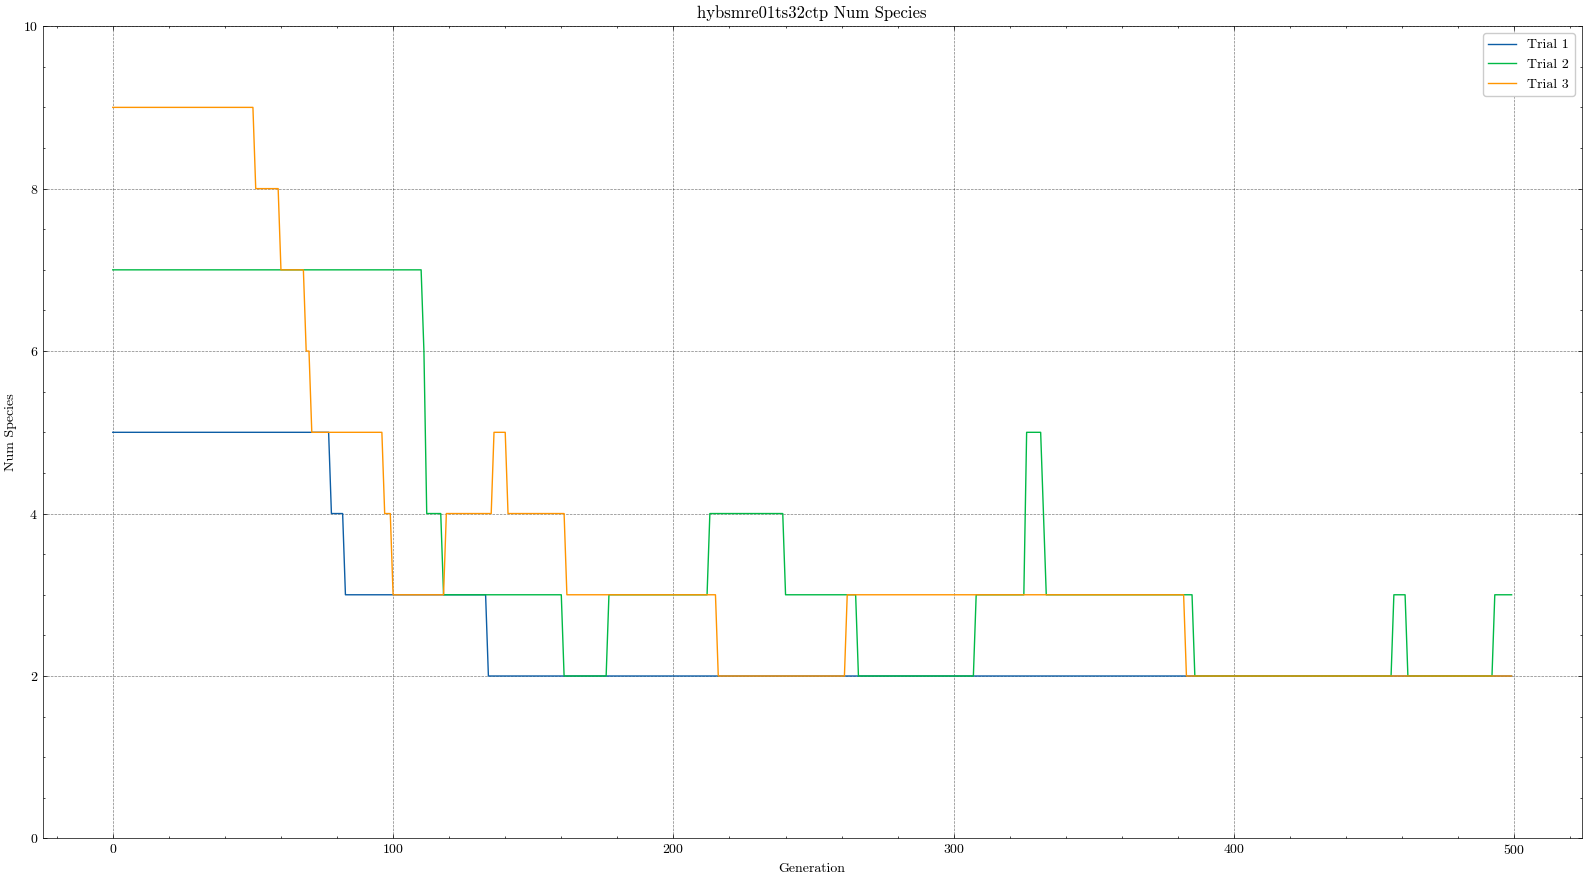

In [8]:
num_trials = 10

for exp_name in exp_name_uniques:
    if os.path.exists(os.path.join(EXP_DIR, f"{exp_name}_num_species.png")):
        continue
    exp_traials = [data_dir for data_dir in data_dirs if data_dir.split("_")[0]==exp_name and "." not in data_dir]
    exp_traials.sort()

    num_row = int(np.ceil(num_trials/3))
    plt.style.use(['science', 'grid', 'no-latex'])
    fig = plt.figure(figsize=(16, 9))

    for i, exp_trial in enumerate(exp_traials[:num_trials]):
        df_history_pop = pd.read_csv(os.path.join(EXP_DIR, exp_trial, "history_pop.csv"))
        num_species_hist = get_num_species_hist(df_history_pop)

        plt.plot(num_species_hist, label=f"Trial {i+1}")

    plt.title(f"{exp_name} Num Species")
    plt.xlabel("Generation")
    plt.ylabel("Num Species")
    plt.legend()

    plt.tight_layout()
    plt.ylim(0, 10)
    plt.savefig(os.path.join(EXP_DIR, f"{exp_name}_num_species.png"))
    plt.show()
    plt.close()

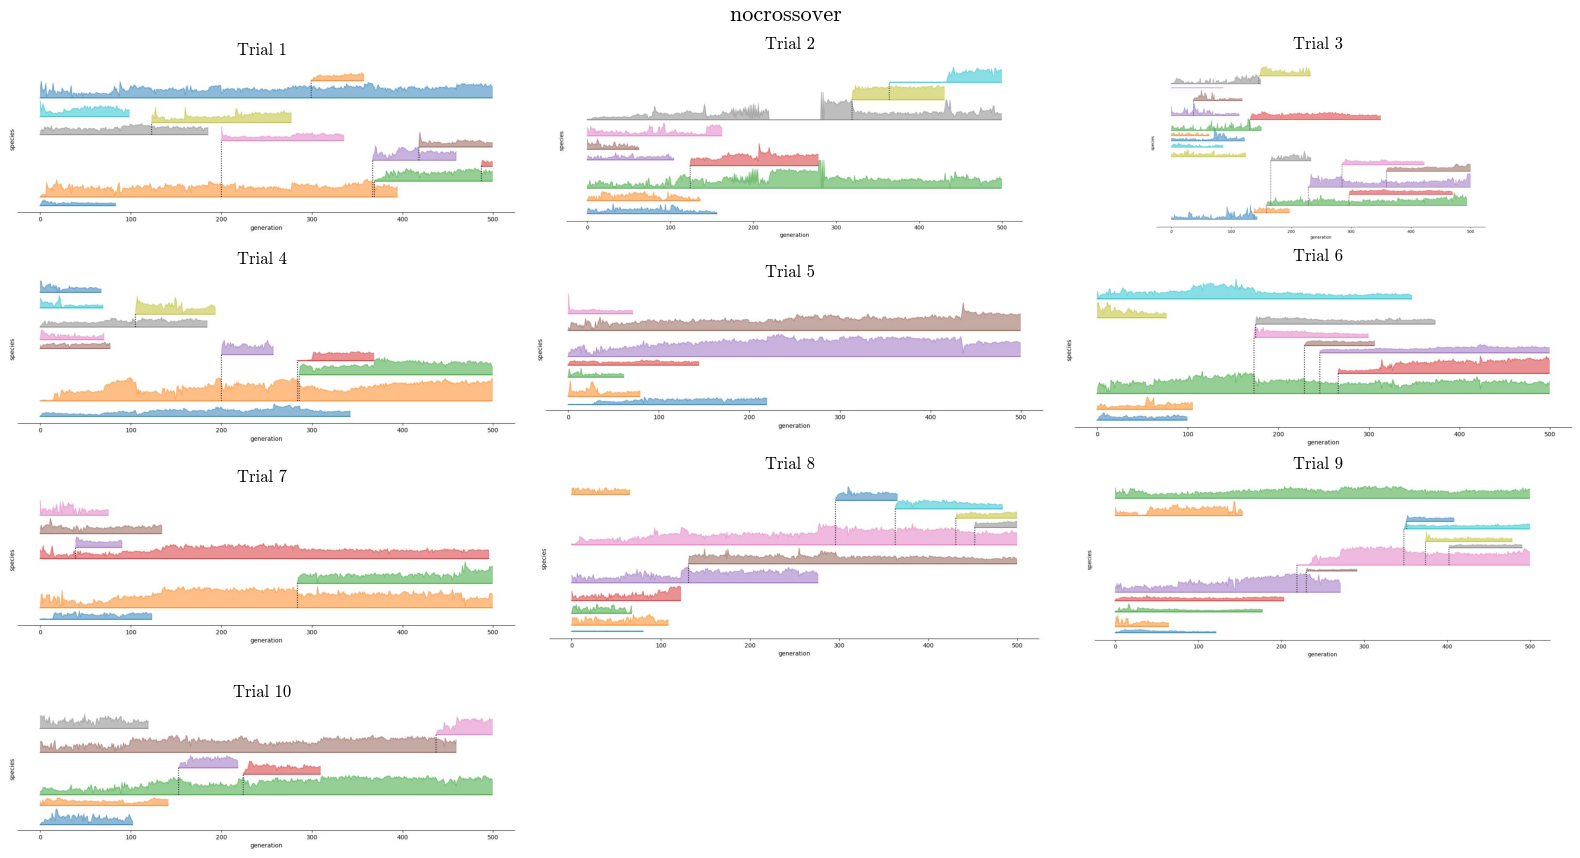

In [11]:
num_trials = 10

for exp_name in exp_name_uniques:
    if os.path.exists(os.path.join(EXP_DIR, f"{exp_name}_species_img.png")):
        continue

    if exp_name == "hybsmre01elitts32v2" or exp_name == "kanneatnocrossover":
        continue
    exp_traials = [data_dir for data_dir in data_dirs if data_dir.split("_")[0]==exp_name and "." not in data_dir]
    exp_traials.sort()

    num_row = int(np.ceil(num_trials/3))
    plt.style.use(['science', 'no-latex'])
    fig = plt.figure(figsize=(16, 9))
    fig.suptitle(f"{exp_name} ", fontsize=16)
    axs = [fig.add_subplot(num_row, 3, i+1) for i in range(num_trials)]
    for i, exp_trial in enumerate(exp_traials[:num_trials]):
        species_img = plt.imread(os.path.join(EXP_DIR, exp_trial, "species.jpg"))

        axs[i].imshow(species_img)
        axs[i].axis("off")
        axs[i].set_title(f"Trial {i+1}")

    plt.tight_layout()
    plt.savefig(os.path.join(EXP_DIR, f"{exp_name}_species_img.png"))
    plt.show()
    plt.close()

In [9]:
num_trials = 10
for exp_name in exp_name_uniques:
    exp_traials = [data_dir for data_dir in data_dirs if data_dir.split("_")[0]==exp_name and "." not in data_dir]
    exp_traials.sort()

    best_fits = []
    for i, exp_trial in enumerate(exp_traials[:num_trials]):
        try:
            df_history_fitness = pd.read_csv(os.path.join(EXP_DIR, exp_trial, "history_fitness.csv"))
        except:
            df_history_fitness = pd.read_csv(os.path.join(EXP_DIR, exp_trial, "history_score.csv"))
        best_fits.append(df_history_fitness["fitness"].max())

    mean = np.mean(best_fits)
    std = np.std(best_fits)
    print(f"{exp_name} Best Fitness: {np.mean(best_fits)} ± {np.std(best_fits)}")

elits100100 Best Fitness: 9340.866464220511 ± 9.795918277182519
elits100200 Best Fitness: 7637.999687232829 ± 2896.2269450212393
elits100400 Best Fitness: 6972.105724185746 ± 3461.6876929270497
elits50200 Best Fitness: 8286.056830373025 ± 2281.369900903177
elits Best Fitness: 8867.345029758842 ± 1393.8797517488172
hybsmre01elitts32v2 Best Fitness: 3754.400826974944 ± 3280.5502159541193
hybsmre01elitts32 Best Fitness: 8535.98814281564 ± 2455.805250322108
hybsmre01ts32ch Best Fitness: 7443.896950705677 ± 3010.350174917146
hybsmre01ts32ctp Best Fitness: 6152.6827184693975 ± 2487.0402924252076
hybsmre01ts32ep0507 Best Fitness: 7002.175254734665 ± 2834.593028928726
hybsmre01ts32stepnocycle Best Fitness: 6676.594416862363 ± 3378.6755879100892
hybsmre01ts32step Best Fitness: 7318.502281160823 ± 3137.750588702254
hybsmre01ts32ts32 Best Fitness: 6367.70821765489 ± 3635.5987626812207
hybsmre01ts32v2 Best Fitness: 5541.59094482728 ± 3236.773689232815
hybsmre01ts32 Best Fitness: 8649.956022230735 

In [5]:
num_trials = 10

for exp_name in exp_name_uniques:
    exp_traials = [data_dir for data_dir in data_dirs if data_dir.split("_")[0]==exp_name and "." not in data_dir]
    exp_traials.sort()

    num_species = []
    for i, exp_trial in enumerate(exp_traials[:num_trials]):
        df_history_pop = pd.read_csv(os.path.join(EXP_DIR, exp_trial, "history_pop.csv"))
        num_specie = len(df_history_pop["species"].unique())
        num_species.append(num_specie)

    mean = np.mean(best_fits)
    print(f"{exp_name} Num Species: {np.mean(num_species)} ± {np.std(num_species)}")

NameError: name 'best_fits' is not defined

In [10]:
exp_name_uniques

['elitencocontraseed5layer4',
 'elitencocontraseed5layer5',
 'elitencocontraseed5',
 'elitencocontra',
 'elitencoleakconstrand',
 'elitencoleak',
 'elitenco',
 'elits100100novelty.png',
 'elits100100',
 'elits100400novelty.png',
 'elits100400',
 'elits200200novelty.png',
 'elits200200',
 'elits50200novelty.png',
 'elits50200',
 'elitsnothnovelty.png',
 'elitsnoth',
 'elitsnovelty.png',
 'elitsupdateelit100100novelty.png',
 'elitsupdateelit100100',
 'elitsupdateelit10050novelty.png',
 'elitsupdateelit10050',
 'elitsupdateelitnovelty.png',
 'elitsupdateelit',
 'elits',
 'hybsmre01elitts32v2',
 'hybsmre01elitts32',
 'hybsmre01ts32ch',
 'hybsmre01ts32ctp',
 'hybsmre01ts32ep0507',
 'hybsmre01ts32stepnocycle',
 'hybsmre01ts32step',
 'hybsmre01ts32ts32',
 'hybsmre01ts32v2',
 'hybsmre01ts32',
 'hybsmre01',
 'hybsmrerandommutate',
 'kanneatnocrossover',
 'kanneat',
 'nocrossover',
 'normalep07',
 'normal',
 'ns',
 'nts32ep07',
 'nts32',
 'smr001',
 'smr01',
 'smre01ep07',
 'smre01hyb',
 'smre01

In [5]:
num_trials = 20
for exp_name in ["elitencocontraseed5layer4", "elitencocontraseed5", "elitencocontraseed5layer5"]:
    exp_traials = [data_dir for data_dir in data_dirs if data_dir.split("_")[0]==exp_name and "." not in data_dir]
    exp_traials.sort()

    best_fits = []
    for i, exp_trial in enumerate(exp_traials[:num_trials]):
        try:
            df_history_fitness = pd.read_csv(os.path.join(EXP_DIR, exp_trial, "history_fitness.csv"))
        except:
            df_history_fitness = pd.read_csv(os.path.join(EXP_DIR, exp_trial, "history_score.csv"))

        if exp_name == "ns":
            best_fits.append(df_history_fitness["score"].max())
            print(f"{exp_name} Best Fitness: {df_history_fitness['score'].max()}")
        else:
            best_fits.append(df_history_fitness["fitness"].max())
            print(f"{exp_name} Best Fitness: {df_history_fitness['fitness'].max()}")

    mean = np.mean(best_fits)
    std = np.std(best_fits)
    print()
    print(f"{exp_name} 10 Trials Best Fitness (Mean ± Std): {mean} ± {std}")
    print(f"Count Under 8000: {len([fit for fit in best_fits if fit<8000])} {len([fit for fit in best_fits if fit<8000])/num_trials*100}%")

elitencocontraseed5layer4 Best Fitness: 9348.736050596644
elitencocontraseed5layer4 Best Fitness: 9356.793056612118
elitencocontraseed5layer4 Best Fitness: 9335.828746516843
elitencocontraseed5layer4 Best Fitness: 9340.666107185709
elitencocontraseed5layer4 Best Fitness: 9333.116350541695
elitencocontraseed5layer4 Best Fitness: 9335.248459912988
elitencocontraseed5layer4 Best Fitness: 1649.8219176359055
elitencocontraseed5layer4 Best Fitness: 2020.130103671809
elitencocontraseed5layer4 Best Fitness: 1113.986256490652
elitencocontraseed5layer4 Best Fitness: 2651.5760868420875
elitencocontraseed5layer4 Best Fitness: 2552.1431118196774
elitencocontraseed5layer4 Best Fitness: 9325.98696563221
elitencocontraseed5layer4 Best Fitness: 4660.721226383894
elitencocontraseed5layer4 Best Fitness: 9291.17816766916
elitencocontraseed5layer4 Best Fitness: 9334.286336165233
elitencocontraseed5layer4 Best Fitness: 2728.452861998284
elitencocontraseed5layer4 Best Fitness: 1101.3416015042153
elitencocont

In [12]:
num_trials = 10
# for exp_name in ["normal", "hybsmre01ts32", "elits", "elits100100", "elits100400", "elits200200", "elits50200", "ns", "elitenco", "elitencoleakconstrand"]:
for exp_name in ["normal", "ns1", "elits100100"]:
    exp_traials = [data_dir for data_dir in data_dirs if data_dir.split("_")[0]==exp_name and "." not in data_dir]
    exp_traials.sort()

    best_fits = []
    for i, exp_trial in enumerate(exp_traials[:num_trials]):
        try:
            df_history_fitness = pd.read_csv(os.path.join(EXP_DIR, exp_trial, "history_fitness.csv"))
        except:
            df_history_fitness = pd.read_csv(os.path.join(EXP_DIR, exp_trial, "history_score.csv"))

        if exp_name == "ns1":
            best_fits.append(df_history_fitness["score"].max())
        else:
            best_fits.append(df_history_fitness["fitness"].max())

    mean = np.mean(best_fits)
    std = np.std(best_fits)
    print(f"{exp_name} Best Fitness: {np.mean(best_fits)} ± {np.std(best_fits)}")

normal Best Fitness: 7955.400055876036 ± 2027.029521129524
ns1 Best Fitness: 2982.6953202919026 ± 2717.9142027578728
elits100100 Best Fitness: 9340.866464220511 ± 9.795918277182519


In [7]:
num_trials = 10
for exp_name in ["normal", "ns", "elits"]:
    exp_traials = [data_dir for data_dir in data_dirs if data_dir.split("_")[0]==exp_name and "." not in data_dir]
    exp_traials.sort()

    num_species = []
    for i, exp_trial in enumerate(exp_traials[:num_trials]):
        df_history_pop = pd.read_csv(os.path.join(EXP_DIR, exp_trial, "history_pop.csv"))
        num_specie = len(df_history_pop["species"].unique())
        num_species.append(num_specie)

    mean = np.mean(best_fits)
    print(f"{exp_name} Num Species: {np.mean(num_species)} ± {np.std(num_species)}")

NameError: name 'best_fits' is not defined

In [ ]:
algo_name = "hybsmre01ts32_1"

file_path = os.path.join(EXP_DIR, algo_name, "genome")

# ファイル名のリストを取得
file_names = os.listdir(file_path)
file_names.sort(key=lambda x: int(x.split(".")[0]), reverse=True)
print(file_names[0])

69662.pickle


In [15]:
# ファイルを読み込む
col_names = ["id(key)", "fitness", "num_input", "num_output", "num_hidden", "num_connection", "num_params"]
algo_names = ["normal", "ns1", "elits100100"]
# algo_names = ["normal", "elits100100"]
df = pd.DataFrame()

for an in algo_names:
    df = pd.DataFrame()
    for i in range(2, 10):
        # print(f"Trial {i}")
        algo_name = an + "_" + str(i)

        file_path = os.path.join(EXP_DIR, algo_name, "genome")

        # ファイル名のリストを取得
        file_names = os.listdir(file_path)
        file_names.sort(key=lambda x: int(x.split(".")[0]), reverse=True)
        # print(file_names[0])
        file_path = os.path.join(file_path, file_names[0])
        with open(file_path, "rb") as f:
            genome = pickle.load(f)

        num_out = 1
        num_input = 11
        network_info = {
            "id(key)": genome.key,
            "fitness": genome.fitness,
            "num_input": num_input,
            "num_output": num_out,
            "num_hidden": None,
            "num_connection": None,
            "num_params": None
        }

        network_info["num_hidden"] = len(genome.nodes) - num_out
        network_info["num_connection"] = len(genome.connections)
        network_info["num_params"] = network_info["num_connection"]

        df = pd.concat([df, pd.DataFrame(network_info, index=[i])])

        # print(network_info)
        # print()
    mean_num_hidden = df["num_hidden"].mean()
    std_num_hidden = df["num_hidden"].std()
    mean_num_connection = df["num_connection"].mean()
    std_num_connection = df["num_connection"].std()
    mean_fit = df["fitness"].mean()
    std_fit = df["fitness"].std()

    print(f"Algo: {an}")
    print(f"Mean Fitness: {mean_fit} ± {std_fit}")
    print(f"Mean Num Hidden: {mean_num_hidden} ± {std_num_hidden}")
    print(f"Mean Num Connection: {mean_num_connection} ± {std_num_connection}")
    print()
    

Algo: normal
Mean Fitness: 8019.336340683689 ± 2406.7949188777566
Mean Num Hidden: 1.875 ± 2.5877458475338284
Mean Num Connection: 9.125 ± 6.334429729659964

Algo: ns1
Mean Fitness: 1275.9397130960892 ± 1477.5113497736202
Mean Num Hidden: 2.125 ± 2.5877458475338284
Mean Num Connection: 7.375 ± 4.718883039751796

Algo: elits100100
Mean Fitness: 3782.819998640558 ± 4249.484876217637
Mean Num Hidden: 2.0 ± 2.0
Mean Num Connection: 10.625 ± 4.373213921133975



In [20]:
df

id(key)      fitness  num_input  num_output  num_hidden  num_connection  \
0    53996  9334.341163         11           1           0               5   
1    62521  1067.281906         11           1           0               2   
2    61849  6134.114805         11           1           0               7   
3    50754  2301.510262         11           1           0               4   
4    62095  1070.996740         11           1           0               3   
5    62680  9065.233864         11           1           0               6   
6    50488  2407.263039         11           1           0               5   
7    64949  6925.706314         11           1           0               5   
8    69488  9330.577158         11           1           0               5   
9    71442  9329.553399         11           1           0               4   

   num_params  
0           5  
1           2  
2           7  
3           4  
4           3  
5           6  
6           5  
7           5  
8           5  
9           4

In [22]:
mean_num_hidden = df["num_hidden"].mean()
std_num_hidden = df["num_hidden"].std()
mean_num_connection = df["num_connection"].mean()
std_num_connection = df["num_connection"].std()
mean_fit = df["fitness"].mean()
std_fit = df["fitness"].std()

print(f"Mean Fitness: {mean_fit} ± {std_fit}")
print(f"Mean Num Hidden: {mean_num_hidden} ± {std_num_hidden}")
print(f"Mean Num Connection: {mean_num_connection} ± {std_num_connection}")

No Crossover
Mean Fitness: 5696.657864865604 ± 3618.78248810689
Mean Num Hidden: 0.0 ± 0.0
Mean Num Connection: 4.6 ± 1.429840705968481
